# Monte Carlo Methods

## Contents

- <a href="#Introduction"> Introduction </a>
- <a href="#Monte-Carlo-Prediction"> Monte Carlo Prediction </a>
- <a href="#Monte-Carlo-Control"> Monte Carlo Control </a>
- <a href="#Coding-Exercises"> Coding Exercises  </a>


<br><br>

## Introduction

**`Monte Carlo methods are ways of solving the reinforcement learning problem based on averaging sample returns.`**
                                                                                                - Sutton & Barto 2018


<br><br>

## Monte Carlo Prediction

#### Pshotdocode for Monte Carlo Prediction

<img src='./image/Monte_Carlo_Prediction_Sutton&Barto.jpg'>

**Input:**

- `env`: An instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: A 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `gamma`: The discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: A very small positive number that is used to decide if the estimate has sufficiently converged to the true value function (default value: `1e-8`).

**Output:**
- `V`: A 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s` under the input policy.

<br><br>

## Monte Carlo Control

#### Pshotdocode for Monte Carlo Control

<img src='./image/Monte_Carlo_Control_Sutton&Barto.jpg'>

**Input:**

- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

**Output:**

- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.
<br><br><br>

## Coding Exercises

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from lib import utils

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
# Basic information about the environment
print('Instance:', env)
print('Observation Space:',env.observation_space)
print('Action Space:',env.action_space)

Instance: <BlackjackEnv<Blackjack-v0>>
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action Space: Discrete(2)


In [4]:
# The master class
class Monte_Carlo(object):
    def __init__(self):
        super(Monte_Carlo, self).__init__()
        pass

    def generate_episode(self, env):
        episode = []
        state = env.reset()
        while True:
            probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
            action = np.random.choice(np.arange(2), p=probs)
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode

    def mc_q(self, env, num_episodes, gamma=1.0):
        returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
        N = defaultdict(lambda: np.zeros(env.action_space.n))
        Q = defaultdict(lambda: np.zeros(env.action_space.n))

        for i_episode in range(1, num_episodes+1):
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
                sys.stdout.flush()

            episode = self.generate_episode(env)
            states, actions, rewards = zip(*episode)
            discounts = np.array([gamma**i for i in range(len(rewards)+1)])

            for i, state in enumerate(states):
                returns_sum[state][actions[i]
                                   ] += sum(rewards[i:]*discounts[:-(1+i)])
                N[state][actions[i]] += 1.0
                Q[state][actions[i]] = returns_sum[state][actions[i]] / \
                    N[state][actions[i]]
        return Q

    def mc_prediction(self, env, num_episodes, gamma):
        Q = self.mc_q(env, num_episodes, gamma)
        V = dict((k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0]
                                                              <= 18) * (np.dot([0.2, 0.8], v))) for k, v in Q.items())
        return V

    def get_probs(self, Q_s, epsilon, nA):
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s

    def Q_episode(self, env, Q, epsilon, nA):
        episode = []
        state = env.reset()
        while True:
            action = np.random.choice(np.arange(nA), p=self.get_probs(Q[state], epsilon, nA)) \
                if state in Q else env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode

    def update_Q(self, env, episode, Q, alpha, gamma):
        states, actions, rewards = zip(*episode)

        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = Q[state][actions[i]]
            Q[state][actions[i]] = old_Q + alpha * \
                (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
        return Q

    def mc_control(self, env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
        nA = env.action_space.n

        Q = defaultdict(lambda: np.zeros(nA))
        epsilon = eps_start

        for i_episode in range(1, num_episodes+1):

            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
                sys.stdout.flush()
            epsilon = max(epsilon*eps_decay, eps_min)
            episode = self.Q_episode(env, Q, epsilon, nA)
            Q = self.update_Q(env, episode, Q, alpha, gamma)
        policy = dict((k, np.argmax(v)) for k, v in Q.items())
        return policy, Q


In [5]:
mc = Monte_Carlo()

### Run Monte Carlo Prediction

Episode 500000/500000.

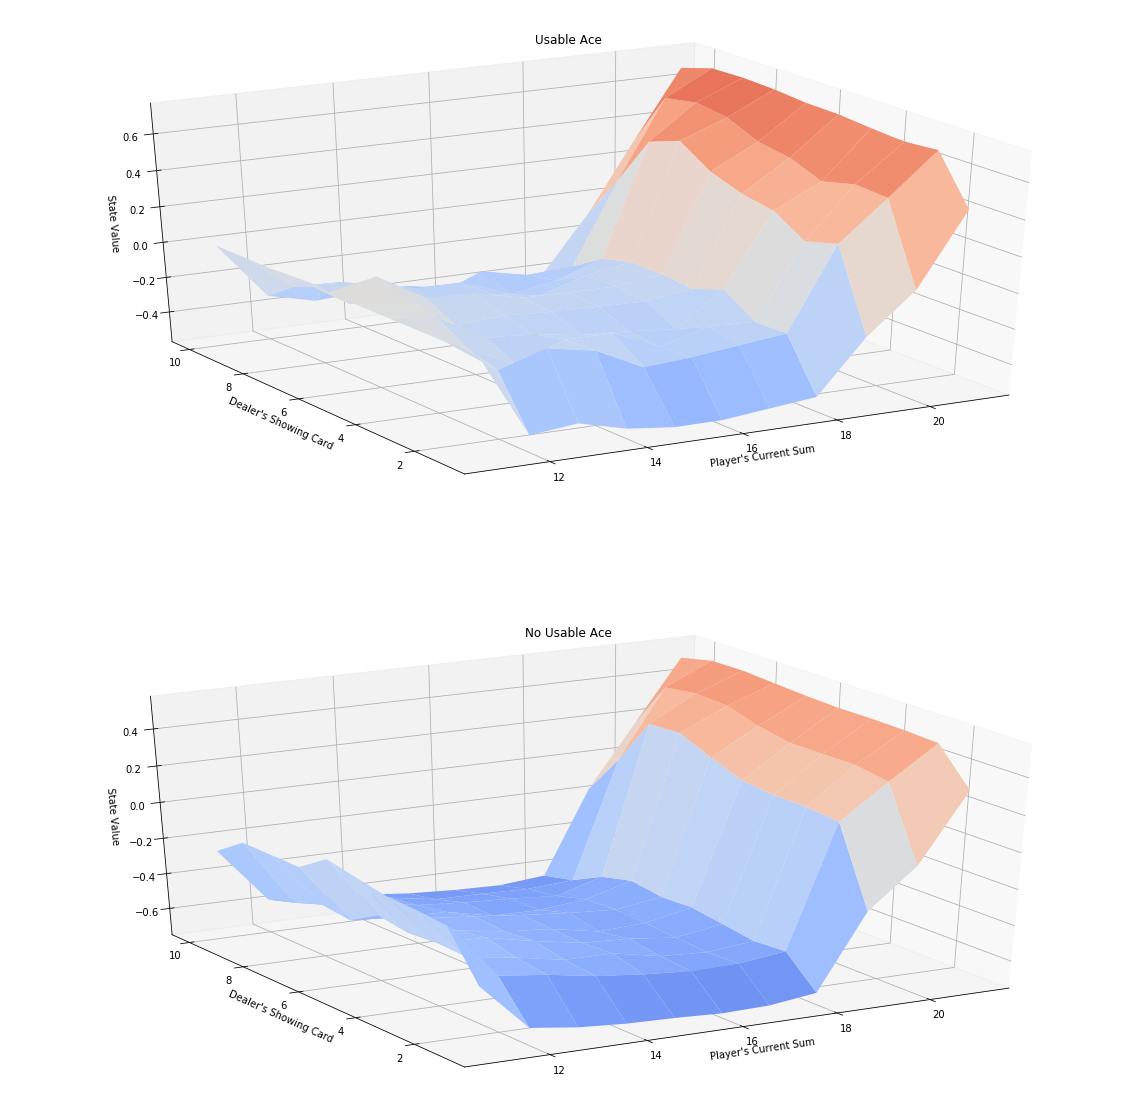

In [6]:
value = mc.mc_prediction(env, num_episodes=500000, gamma=1.0)
utils.visualization(value)

### Monte Carlo Control

Episode 500000/500000.

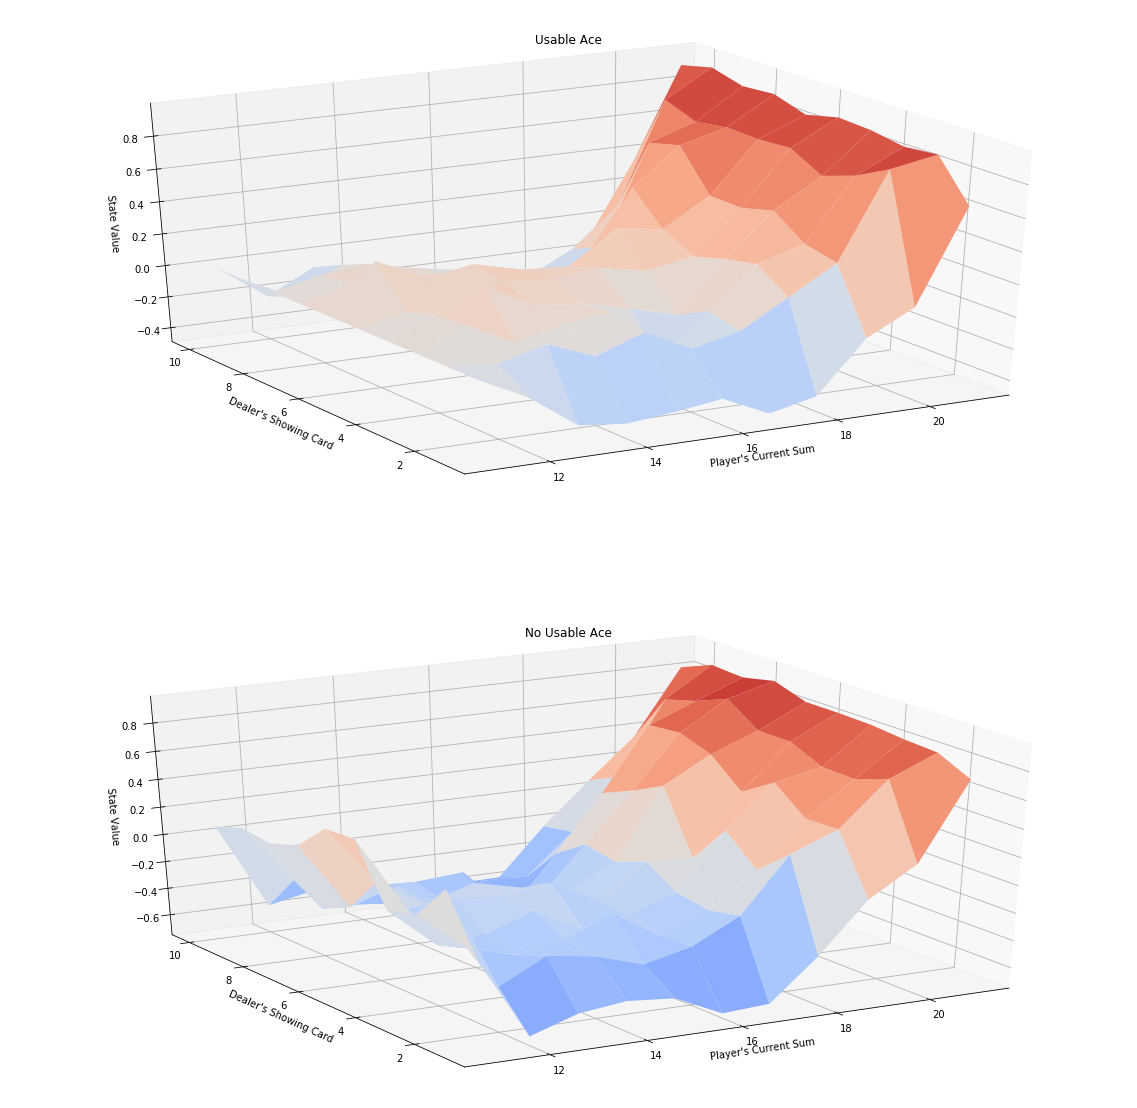

In [7]:
policy, Q = mc.mc_control(env, 500000, 0.02)
V = dict((k,np.max(v)) for k, v in Q.items())
utils.visualization(V)